In [4]:
import bptf
from bptf import BPTF
import numpy as np
import pandas as pd
import sparse
import os
import shutil
from tqdm import tqdm
import pickle
import scipy.stats as st
import matplotlib.pyplot as plt
import torch
import tensorly
import cupy

import multiprocessing
from joblib import Parallel, delayed
from tqdm.contrib.concurrent import process_map

In [5]:
def dataframe_to_sparse_tensor(data, country_indices, date_indices, database_indices, cameo_col='CAMEO_Code', events_col='Num_Events'):
    """
    Converts a pandas DataFrame into an sptensor.
    
    Parameters:
        data (pd.DataFrame): The DataFrame containing the data.
        country_indices (pd.DataFrame): DataFrame with country indices.
        date_indices (pd.DataFrame): DataFrame with date indices.
        database_indices (pd.DataFrame): DataFrame with database indices.
        cameo_col (str): Name of the CAMEO code column in 'data'. Defaults to 'CAMEO_Code'.
        events_col (str): Name of the column containing event counts in 'data'. Defaults to 'Num_Events'.
    
    Returns:
        sptensor: The resulting sparse tensor.
    """
    
    # Define the shape of the tensor (V, V, A, T, D)
    V = len(country_indices)
    A = 20  # Assuming the CAMEO code has 20 distinct values
    T = len(date_indices)
    D = len(database_indices)
    
    shape = (V, V, A, T, D)
    
    # Initialize empty subs and vals
    subs = ([], [], [], [], [])
    vals = []

    # Iterate through the DataFrame to populate the tensor
    for i in range(len(data)):

        source_country = country_indices.loc[country_indices['country'] == data['Source_Country_Code'].iloc[i]]
        source_country_index = int(source_country.iloc[0, 1])

        target_country = country_indices.loc[country_indices['country'] == data['Target_Country_Code'].iloc[i]]
        target_country_index = int(target_country.iloc[0, 1])

        action_index = int(data[cameo_col].iloc[i] - 1)  # Adjust CAMEO code to 0-based index

        date = date_indices.loc[date_indices['date'] == data['formatteddate'].iloc[i]]
        date_index = int(date.iloc[0, 1])

        database = database_indices.loc[database_indices['database'] == data['Database'].iloc[i]]
        database_index = int(database.iloc[0, 1])

        # Append indices and values
        subs[0].append(source_country_index)
        subs[1].append(target_country_index)
        subs[2].append(action_index)
        subs[3].append(date_index)
        subs[4].append(database_index)
        vals = np.append(vals, data[events_col].iloc[i])

    # Convert subs to a tuple of numpy arrays and vals to a numpy array
    subs = tuple(np.array(s, dtype=int) for s in subs)
    vals = np.array(vals)

    # Create the sparse COO tensor
    Y = sparse.COO(coords=subs, data=vals, shape=shape)
    
    return Y

def add_sparse_tensors(tensor1, tensor2):
    assert tensor1.shape == tensor2.shape, "Tensors must have the same shape to be added."
    
    # Directly add the two tensors
    result_tensor = tensor1 + tensor2
    
    return result_tensor


def sum_sparse_tensor_list(tensor_list):
    if not tensor_list:
        raise ValueError("The list of tensors is empty.")
    
    # Use sum with a starting tensor of 0 in the shape of the tensors
    result_tensor = sum(tensor_list[1:], start=tensor_list[0])
    
    return result_tensor

# Make the list of countries, actions, times and databases

In [6]:
# read files by batch
folder = "\\dyadic_data_2000_2020_inclusive\\"
data_filepath = os.getcwd() + folder
files = os.listdir(data_filepath)
for filepath in tqdm(files, desc = 'Reading data'):
    complete_filepath = data_filepath + filepath
    file = pd.read_csv(complete_filepath)
    if filepath == files[0]:
        data = file
    else:
        data = pd.concat([data, file])
    del file
data = data.sort_values(by='Num_Events', ascending=False)

# filter by date to get a smaller dataset to play around with
# Also my laptop can only fit a 10/11 year dataset
years = [str(2000 + x) for x in range(0, 21)]
data = data[data['formatteddate'].str.startswith(tuple(years))]

# collapse by month
data['formatteddate'] = data['formatteddate'].str[:7]
data = data.groupby(['Source_Country_Code', 'Target_Country_Code', 'CAMEO_Code', 'formatteddate', 'Database'])
data = data.sum().reset_index()

# get unique list of countries
countries = pd.concat([data['Source_Country_Code'], data['Target_Country_Code']])
countries = pd.unique(countries)
country_indices = pd.DataFrame({
    'country' : countries,
    'index' : range(len(countries))
})
del countries

# there's no need to get a list of actions since it's just 1 to 20

# get unique list of dates
# Make sure to change the date format and frequency of the date range if you change the time unit
date_indices = pd.date_range(
    start=pd.to_datetime(data['formatteddate'], format='%Y-%m').min().strftime('%Y-%m'), 
    end=pd.to_datetime(data['formatteddate'], format='%Y-%m').max().strftime('%Y-%m'),
    freq='MS')
date_indices = date_indices.strftime('%Y-%m').to_list()
date_indices = pd.DataFrame({
    'date' : date_indices,
    'index' : range(len(date_indices))
})
date_indices['date'] = date_indices['date'].str[:7]

# get unique list of databases
databases = pd.unique(data['Database'])
databases = pd.unique(databases)
database_indices = pd.DataFrame({
    'database' : databases,
    'index' : range(len(databases))
})
del databases

Reading data: 100%|██████████| 85/85 [00:59<00:00,  1.44it/s]


C:\Users\luiyu\AppData\Local\Temp\ipykernel_12708\4002269932.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  db_subdf['Year'] = db_subdf['formatteddate'].str[:4]


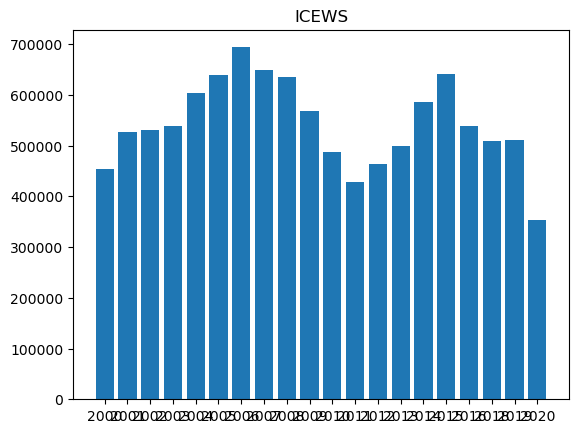

C:\Users\luiyu\AppData\Local\Temp\ipykernel_12708\4002269932.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  db_subdf['Year'] = db_subdf['formatteddate'].str[:4]


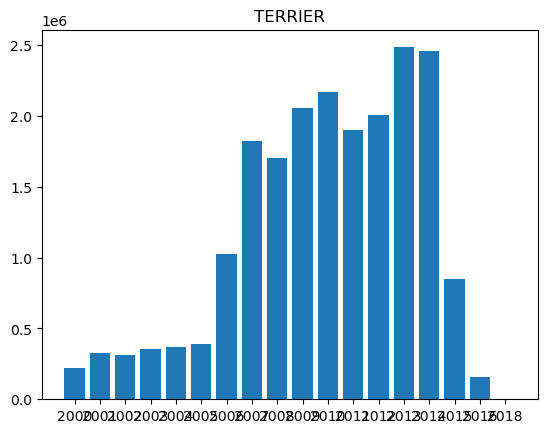

C:\Users\luiyu\AppData\Local\Temp\ipykernel_12708\4002269932.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  db_subdf['Year'] = db_subdf['formatteddate'].str[:4]


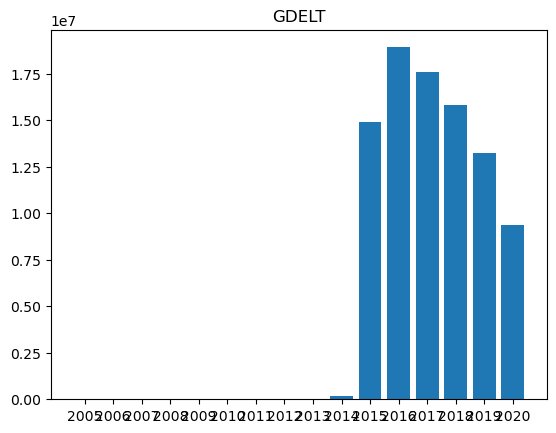

In [12]:
for db in ['ICEWS', 'TERRIER', 'GDELT']:
    db_subdf = data[data['Database'] == db]
    db_subdf['Year'] = db_subdf['formatteddate'].str[:4]
    db_subdf = db_subdf.groupby('Year', as_index=False)['Num_Events'].sum()
    plt.bar(db_subdf['Year'], db_subdf['Num_Events'])
    plt.title(f'{db}')
    plt.show()